# t-SNE template
## Imports

In [1]:
import os
import sys
from collections import OrderedDict
import datetime

from dotenv import load_dotenv
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

#os.chdir("<path to helpers>")
from kaldi_io import *

## Set paths and commands

In [2]:
root = "../../kaldi-for-dummies"
data = os.path.join(root, "data/train")
model_dir = os.path.join(root, "exp/mono")
feats_command = f"apply-cmvn --utt2spk=ark:{data}/utt2spk scp:{data}/cmvn.scp scp:{data}/feats.scp ark:- | add-deltas ark:- ark,t:-"

## Read alis, feats, and phone mapping(int->symb)

In [3]:
phones_mapping = phone_int2symb(os.path.join(model_dir, "phones.txt"))
feats = read_feats(feats_command)
alis = read_ali(model_dir)

## Make sure feats and alis have same utterances in exactly  the same order

In [5]:
feat_utterances = set(feats.keys())
ali_utterances = set(alis.keys())
if feat_utterances != ali_utterances:
    for k in feat_utterances.difference(ali_utterances):
        print(f"WARNING: There is no alignment for {k}, so removing it")
        del feats[k]
    for k in ali_utterances.difference(feat_utterances):
        print(f"WARNING: There are no feats for {k}, so removing it")
        del alis[k]
    assert set(feats.keys()) == set(alis.keys())
    feats = OrderedDict(feats)
alis = OrderedDict(alis)
assert feats.keys() == alis.keys()

## Join values of all utterances into one matrix/array

In [7]:
X = np.vstack(tuple(feats.values()))
phones = np.concatenate(tuple(alis.values()))
utterances = []
for utter in alis.keys():
    utterances = utterances + [utter]*len(alis[utter])
assert X.shape[0] == len(phones)
assert len(utterances) == len(phones)
# Category needs less memory and works faster
phones = pd.Series(phones, dtype="category").cat.rename_categories(phones_mapping)
utterances = pd.Series(utterances, dtype="category")

In [8]:
# Save values to reuse them
#np.save("../test/tmp/X.npy", X)
#pd.DataFrame({"phone":phones, "utterance":utterances}).to_csv("../test/tmp/labesl.csv", index=False)

## Compute and plot t-SNE

In [9]:
# Restrict number of rows
indexes = range(len(phones))#np.random.choice(np.arange(0,X.shape[0]), 2500, replace=False)

In [13]:
# Plot
print(datetime.datetime.now())
X_transformed = TSNE(n_components=2, init="pca", perplexity=100).fit_transform(X[indexes,:])
print(datetime.datetime.now())

2019-08-19 18:56:20.573915
2019-08-19 18:57:13.523821


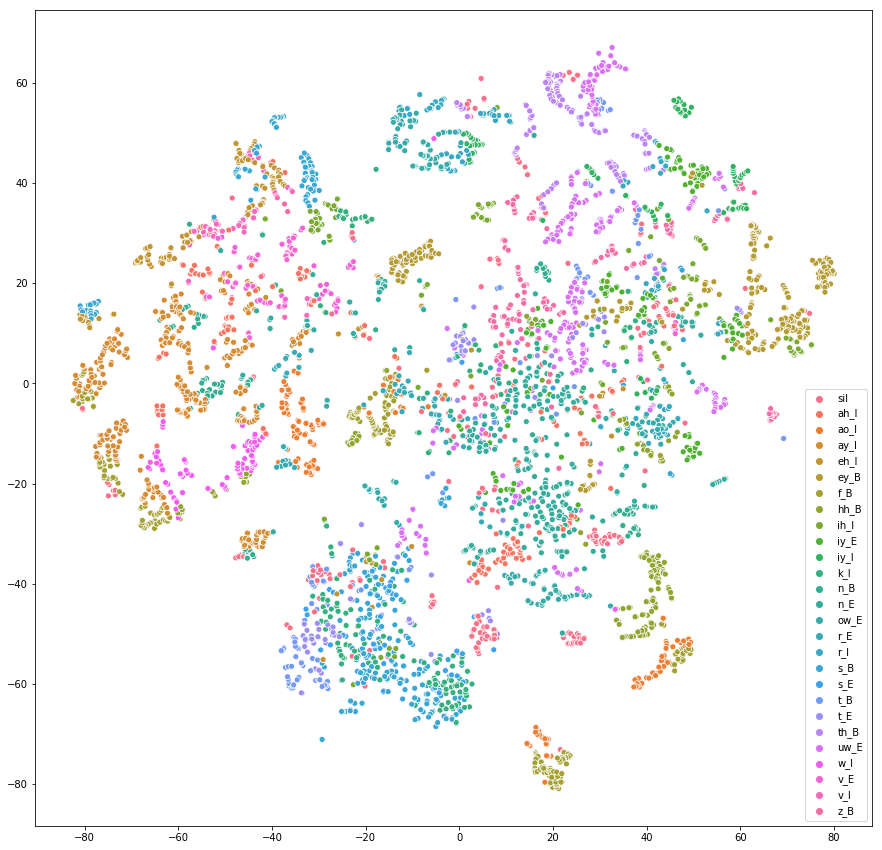

In [14]:
# Plot
plt.figure(figsize=(15,15))
sns.scatterplot(X_transformed[:, 0], X_transformed[:, 1], hue=phones);
plt.show()